# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

import seaborn as sns
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [6]:
features_by_type = df.columns.to_series().groupby(df.dtypes).groups
features_by_type

{dtype('int64'): Index(['encounter_id', 'patient_nbr', 'admission_type_id',
        'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
        'number_outpatient', 'number_inpatient', 'number_emergency',
        'num_lab_procedures', 'number_diagnoses', 'num_medications',
        'num_procedures'],
       dtype='object'),
 dtype('O'): Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
        'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
        'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
       dtype='object')}

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

**Answer**: The dataset is at the line level because the number of rows is greater than the number of unique encounters. I will show some elaborations below to justify my answer:

In [7]:
df.shape, df.encounter_id.nunique(), df.patient_nbr.nunique()

((143424, 26), 101766, 71518)

In [8]:
## Line Test
try:
    assert len(df) > df['encounter_id'].nunique() 
    print("Dataset could be at the line level")
except:
    print("Dataset is not at the line level")

Dataset could be at the line level


In [9]:
## Encounter Test
try:
    assert len(df) == df['encounter_id'].nunique()
    print("Dataset could be at the encounter level")
except:
    print("Dataset is not at the encounter level")

Dataset is not at the encounter level


In [10]:
## Longitudinal Test
try:
    assert len(df) == df['patient_nbr'].nunique()
    print("Dataset could be at the longitudinal level")
except:
    print("Dataset is not at the longitudinal level")

Dataset is not at the longitudinal level


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Answer**: 
* a: `weight`, `medical_specialty`, `payer_code`, and `ndc_code` have a high amount of missing/zeros values. The 0 values for numerical fields like `number_outpatient` or `number_emergency`, are valid values (should not be considered as missing) since they indicate the person has not been an outpatient or had emergency visits (in the year preceding the encounter). Also 'None' values found in `max_glu_serum` and `A1Cresult` are valid values as stated in the Schema Sheet. 	
* b: `num_medications`(avg. approx. 17),`time_in_hospital`(skewed left, avg. approx. 4.5 days) and `num_lab_procecures`(avg. approx. 43) have a Gaussian(normal) distribution shape
* c: High cardinality fields are: `other_diagnosis_codes`(19374) - there is a very wide variety of other diagnoses, `primary_diagnosis_code`(717) - there is a wide variety of primary diagnoses, `ndc_code`(252) - wide variety of drugs prescribed to patients during visits, `medical_specialty`(73) - different medical specialists attended to the patients
* d: `gender` fields is almost equal between Male and Female with a slightly higher amount of Female. `age` is a categorial fields and looks like it is distributed normaly with a peak around 70-80 years.

In [11]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

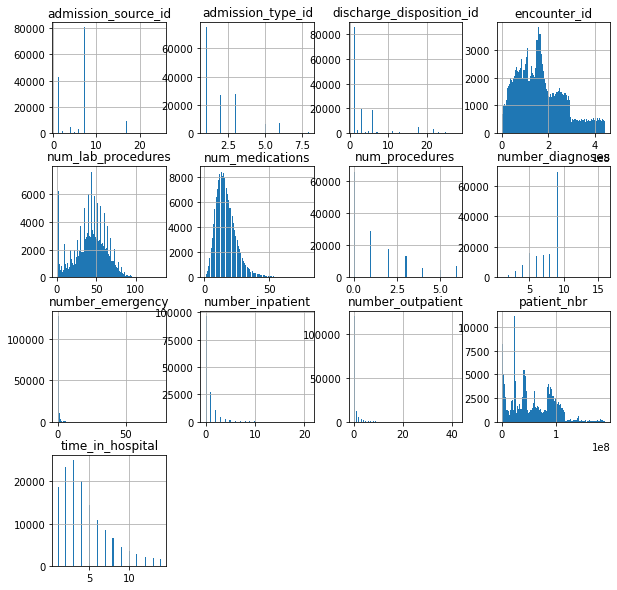

In [12]:
%matplotlib inline
df.hist(figsize=(10,10), bins=100)
plt.show()

In [13]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
primary_diagnosis_code          0
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergency                0
num_lab_procedures              0
number_diagnoses                0
num_medications                 0
num_procedures                  0
ndc_code                    23462
max_glu_serum                   0
A1Cresult                       0
change                          0
readmitted                      0
dtype: int64

In [14]:
df.apply(pd.Series.nunique)

encounter_id                101766
patient_nbr                  71518
race                             6
gender                           3
age                             10
weight                          10
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
payer_code                      18
medical_specialty               73
primary_diagnosis_code         717
other_diagnosis_codes        19374
number_outpatient               39
number_inpatient                21
number_emergency                33
num_lab_procedures             118
number_diagnoses                16
num_medications                 75
num_procedures                   7
ndc_code                       251
max_glu_serum                    4
A1Cresult                        4
change                           2
readmitted                       3
dtype: int64

In [15]:
def get_unique_values(col_name):
    return list(df[col_name].unique())
    
def get_records(col_name, value):
    return df[(df[col_name] == value)]

In [16]:
feature_names = []
feature_num_unique = []
feature_missing_value = []
feature_num_missing = []
feature_num_null = []
feature_values = []
feature_percent_missing_or_null = []

for f in features_by_type[np.dtype('object')]:
    values = get_unique_values(f)
    feature_names.append(f)
    feature_values.append(values)
    feature_num_unique.append(len(values))
    num_null = df[f].isnull().sum()
    feature_num_null.append(num_null)
    num_missing_or_null = num_null
    has_missing = False
    for s in ['?', '?|?', 'Unknown/Invalid']:
        if s in values:
            m = len(get_records(f, s))
            feature_missing_value.append(s)
            feature_num_missing.append(m)
            num_missing_or_null += m
            has_missing = True
            break
    if not has_missing:
        feature_missing_value.append('')
        feature_num_missing.append(0)
    feature_percent_missing_or_null.append(100*(num_missing_or_null/len(df)))
        

df_info = pd.DataFrame.from_dict({
    'name': feature_names,
    'num unique values': feature_num_unique,
    'missing notation': feature_missing_value,
    'num missing': feature_num_missing,
    'num null': feature_num_null,
    'missing or null (%)': feature_percent_missing_or_null,
    'values': feature_values
})
df_info

,name,num unique values,missing notation,num missing,num null,missing or null (%),values
0,race,6,?,3309,0,2.307145,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
1,gender,3,Unknown/Invalid,5,0,0.003486,"[Female, Male, Unknown/Invalid]"
2,age,10,,0,0,0.000000,"[[0-10), [10-20), [20-30), [30-40), [40-50), [..."
3,weight,10,?,139122,0,97.000502,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
4,payer_code,18,?,54190,0,37.783077,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH..."
5,medical_specialty,73,?,69463,0,48.431922,"[Pediatrics-Endocrinology, ?, InternalMedicine..."
6,primary_diagnosis_code,717,?,33,0,0.023009,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,..."
7,other_diagnosis_codes,19374,?|?,340,0,0.237059,"[?|?, 250.01|255, 250|V27, 250.43|403, 157|250..."
8,ndc_code,252,,0,23462,16.358490,"[nan, 68071-1701, 0378-1110, 0049-4110, 47918-..."
9,max_glu_serum,4,,0,0,0.000000,"[None, >300, Norm, >200]"


### Fields with high amount of missing/zeros values > 10%

In [17]:
df_info_missing = df_info[['name', 'missing or null (%)']]
df_info_missing[df_info_missing['missing or null (%)'] > 10.0]

,name,missing or null (%)
3,weight,97.000502
4,payer_code,37.783077
5,medical_specialty,48.431922
8,ndc_code,16.358490


### Fields with high cardinality features > 20 unique values

In [18]:
df_info_unique = df_info[['name', 'num unique values', 'values']]
df_info_unique[df_info_unique['num unique values'] > 20.0]

,name,num unique values,values
5,medical_specialty,73,"[Pediatrics-Endocrinology, ?, InternalMedicine..."
6,primary_diagnosis_code,717,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,..."
7,other_diagnosis_codes,19374,"[?|?, 250.01|255, 250|V27, 250.43|403, 157|250..."
8,ndc_code,252,"[nan, 68071-1701, 0378-1110, 0049-4110, 47918-..."


### Numerical fields have normal distribution

In [19]:
df.select_dtypes(['int64']).columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures'],
      dtype='object')

In [20]:
num_col = ['encounter_id', 'patient_nbr', 'time_in_hospital', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures']
df[num_col].describe()

,encounter_id,patient_nbr,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


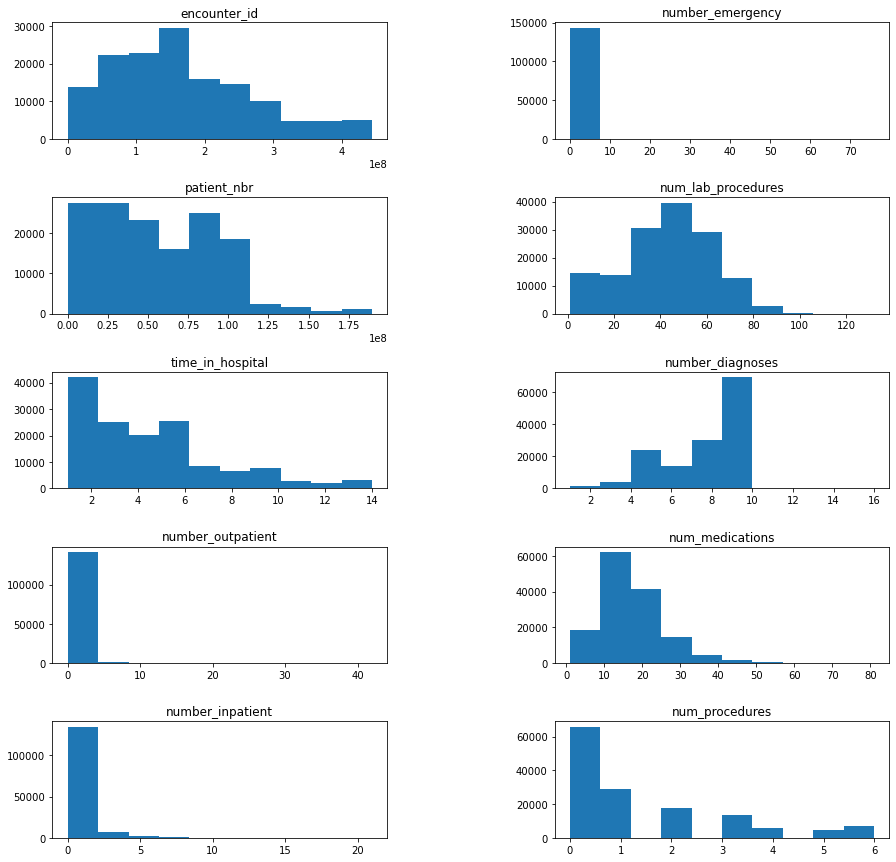

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
for row in range(5):
    for col in range(2):
        field_name = num_col[row+col*5]
        axes[row, col].hist(df.dropna(subset=[field_name])[field_name])
        axes[row, col].title.set_text(field_name)

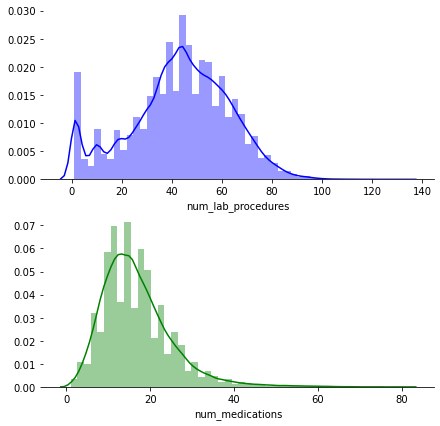

In [22]:
## Identifying and showing fields with Gaussian distribution shapes
f, axes = plt.subplots(2, figsize=(7, 7))
sns.despine(left=True)
sns.distplot(df['num_lab_procedures'], color="b", ax=axes[0])
sns.distplot(df['num_medications'], color="g", ax=axes[1]);

### Demographic distributions in the dataset for the age and gender fields

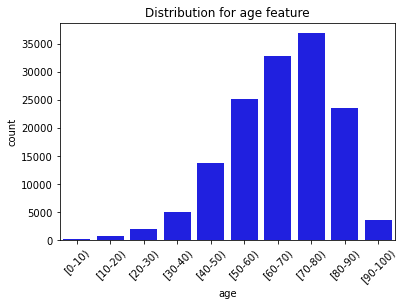

In [23]:
fig = sns.countplot(x='age', color="b", data=df)
fig.set_title('Distribution for age feature');
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);

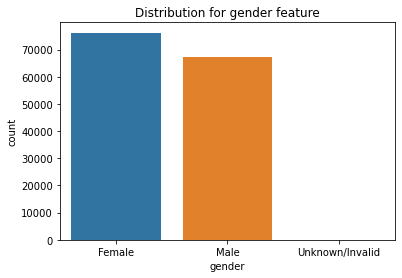

In [24]:
fig = sns.countplot(x="gender", data=df)
fig.set_title('Distribution for gender feature');

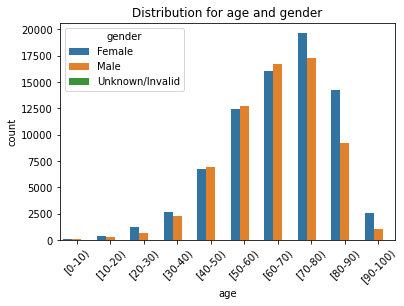

In [25]:
fig = sns.countplot(x="age", hue="gender", data=df);
fig.set_title('Distribution for age and gender');
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

**Answer**: Number of drug names reduced from 251 to 22.

In [26]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [27]:
ndc_code_df.describe()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
count,269,269,269,267,264,267,267
unique,267,39,24,9,2,68,1
top,0781-5634,Metformin Hydrochloride,Metformin Hydrochloride,Tablet,Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
freq,2,61,71,159,263,17,267


In [28]:
ndc_code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   NDC_Code              269 non-null    object
 1   Proprietary Name      269 non-null    object
 2   Non-proprietary Name  269 non-null    object
 3   Dosage Form           267 non-null    object
 4   Route Name            264 non-null    object
 5   Company Name          267 non-null    object
 6   Product Type          267 non-null    object
dtypes: object(7)
memory usage: 14.8+ KB


In [29]:
ndc_code_df[(ndc_code_df['Non-proprietary Name'] == 'Metformin Hydrochloride')]

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
87,42291-610,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,"Avkare, Inc.",Human Prescription Drug
88,42291-611,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,"Avkare, Inc.",Human Prescription Drug
89,42385-902,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Laurus Labs Limited,Human Prescription Drug
90,42385-903,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Laurus Labs Limited,Human Prescription Drug


In [30]:
import importlib
import student_utils
from student_utils import reduce_dimension_ndc

In [31]:
importlib.reload(student_utils)
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [32]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

print(f'Reduced from {df["ndc_code"].nunique()} to {reduce_dim_df["generic_drug_name"].nunique()}')

Reduced from 251 to 22


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

**Answer**: First encounters per patient successfuly selected

In [33]:
from student_utils import select_first_encounter
importlib.reload(student_utils)

first_encounter_df = select_first_encounter(reduce_dim_df)

In [34]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [35]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [36]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [37]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

**Answer**: 
Based on displays below we came up with the summary:

* encounter_id 
* patient_nbr
* **race** - include, as different races may have different nutritional patterns which could have an effect
* **gender** - include, as some functions of the body are different for males and females
* **age** - include, as age definitely has an effect on how the body reacts to drugs
* weight - exclude, 97% data is missing
* admission_type_id - exclude, non-normal and non-uniform distribution
* discharge_disposition_id - exclude, non-normal and non-uniform distribution
* admission_source_id - exclude, non-normal and non-uniform distribution
* **time_in_hospital** - PREDICTOR_FIELD
* payer_code - exclude, 37.7% of data is missing, the rest 62.3% non-normal and non-uniform distribution, with half of non-missing data having one particular value.
* medical_specialty - exclude, almost 50% of data is missing
* **primary_diagnosis_code** - include, the distribution resembles normal (if codes properly re-arranges on the graph)
* **other_diagnosis_codes** - include
* number_outpatient - exclude, non-normal and non-uniform distribution
* number_inpatient - exclude, non-normal and non-uniform distribution
* number_emergency - exclude, non-normal and non-uniform distribution
* **num_lab_procedures** - include, normal distribution
* number_diagnoses - exclude, non-normal and non-uniform distribution
* **num_medications** - include, normal distribution
* num_procedures - exclude, non-normal and non-uniform distribution
* ndc_code - do not include, use one-hot encoding of the generic drugs
* max_glu_serum - exclude, non-uniform distribution
* A1Cresult - exclude, non-uniform distribution
* change - exclude, non-normal and non-uniform distribution
* readmitted - exclude, non-normal and non-uniform distribution

In [38]:
def show_hist(col, bins=None):
    if bins is None:
        df[col].hist(bins=df[col].nunique())
    else:
        df[col].hist(bins=bins)

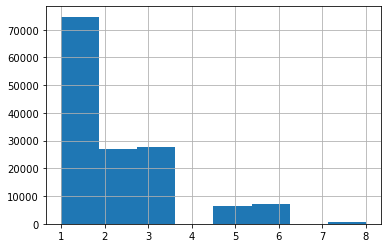

In [39]:
show_hist('admission_type_id')

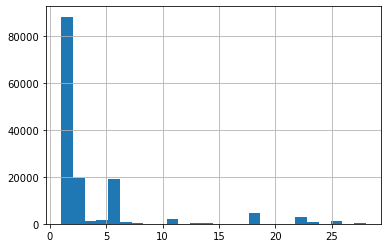

In [40]:
show_hist('discharge_disposition_id')

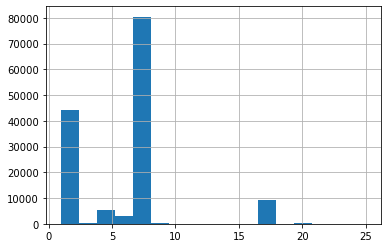

In [41]:
show_hist('admission_source_id')

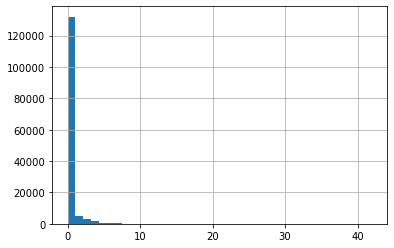

In [42]:
show_hist('number_outpatient')

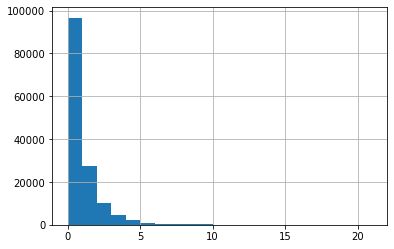

In [43]:
show_hist('number_inpatient')

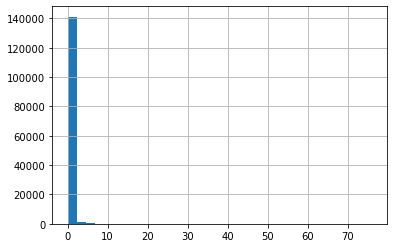

In [44]:
show_hist('number_emergency')

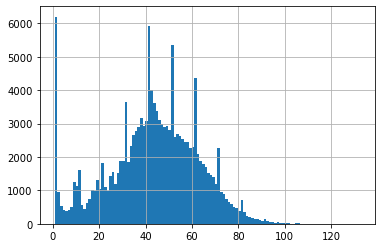

In [45]:
show_hist('num_lab_procedures')

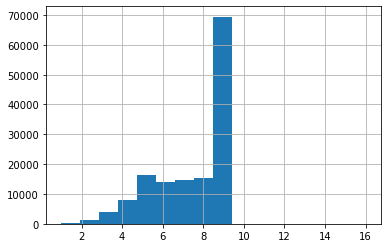

In [46]:
show_hist('number_diagnoses')

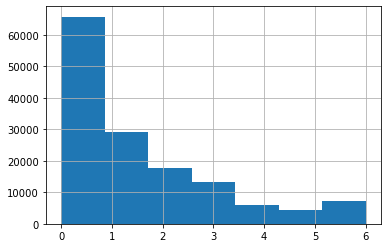

In [47]:
show_hist('num_procedures')

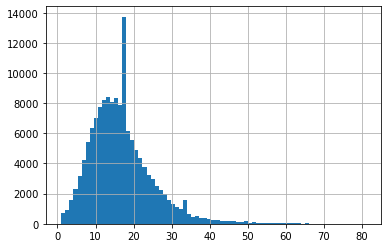

In [48]:
show_hist('num_medications')

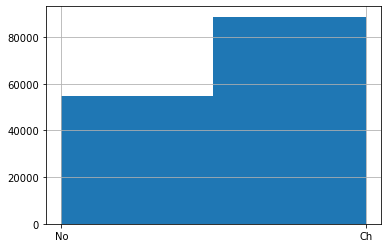

In [49]:
show_hist('change')

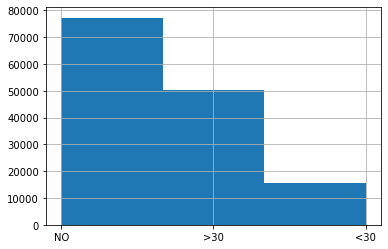

In [50]:
show_hist('readmitted')

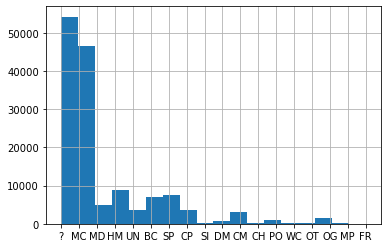

In [51]:
show_hist('payer_code')

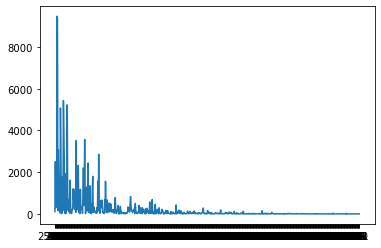

In [52]:
def show_hist2(col):
    primary_diagnosis_num = []
    primary_diagnosis_values = df[col].unique()
    for v in primary_diagnosis_values:
        n = len(df[df[col] == v])
        primary_diagnosis_num.append(n)
    plt.plot(primary_diagnosis_values, primary_diagnosis_num)

##Plot and show the primary diagnoses values    
show_hist2('primary_diagnosis_code')

In [53]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["primary_diagnosis_code", "other_diagnosis_codes"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ["num_lab_procedures", "num_medications"]
PREDICTOR_FIELD = 'time_in_hospital'

In [54]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [55]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [56]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

**Answer**: Data split between train/validation/test sets approx. 60%/20%/20% with number of records: 32562/10854/10855

In [57]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [58]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [59]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


In [60]:
print(f'Train/Validation/Test number of records: {len(d_train)}/{len(d_val)}/{len(d_test)}')

Train/Validation/Test number of records: 32562/10854/10855


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

**Answer**: The distribution of predictor field is similar across train/validation/test sets.

time_in_hospital
1.0     7318
2.0     9191
3.0     9740
4.0     7417
5.0     5348
6.0     3991
7.0     3123
8.0     2311
9.0     1597
10.0    1241
11.0    1008
12.0     783
13.0     663
14.0     540
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


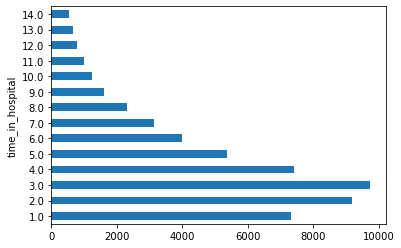

In [61]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4391
2.0     5514
3.0     5844
4.0     4450
5.0     3209
6.0     2394
7.0     1874
8.0     1386
9.0      958
10.0     745
11.0     605
12.0     470
13.0     398
14.0     324
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


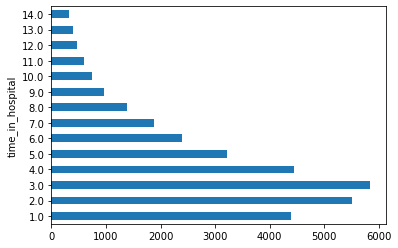

In [62]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1464
2.0     1839
3.0     1948
4.0     1484
5.0     1070
6.0      799
7.0      625
8.0      462
9.0      319
10.0     248
11.0     201
12.0     156
13.0     132
14.0     108
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


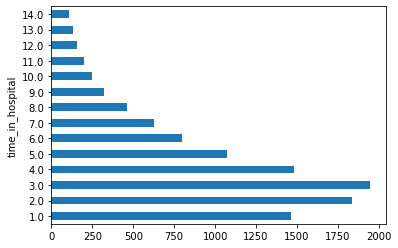

In [63]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             28572
Male               25697
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


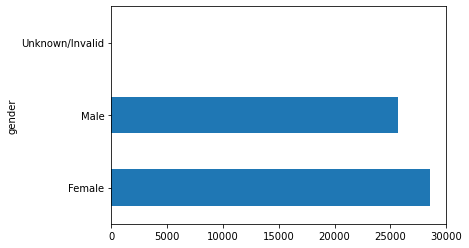

In [64]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             17117
Male               15444
Unknown/Invalid        1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


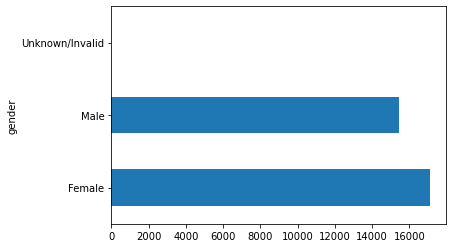

In [65]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             5779
Male               5075
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


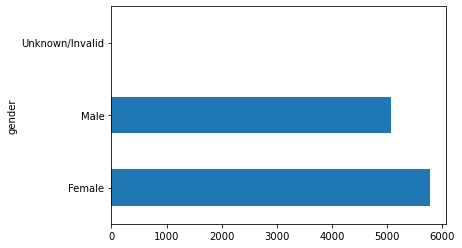

In [66]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [67]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [68]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [69]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

**Answer**:
Categorical Features created, using Embedding Column with 10 dimensions for features with large cardinality ( "primary_diagnosis_code" and "other_diagnosis_codes"):

* race
* gender
* age
* primary_diagnosis_code (embedding, dim=10)
* other_diagnosis_codes (embedding, dim=10)
* one-hot encoded features for each generic drug

In [70]:
importlib.reload(student_utils)
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 608 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
### primary_diagnosis_code: #lines: 608, embedding (categorical)
INFO:tensorflow:vocabulary_size = 9499 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.
### other_diagnosis_codes: #lines: 9499, embedding (categorical)
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
### race: #lines: 7, indicator (categorical)
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
### gender: #lines: 4, indicator (categorical)
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


In [71]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=608, num_oov_buckets=0, dtype=tf.string, default_value=-1), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcd5fb67750>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
tf.Tensor(
[[ 0.29263207  0.22079413  0.07564887 ...  0.24461283  0.11408439
   0.01670578]
 [-0.17102484 -0.07386487 -0.13206156 ...  0.29352078 -0.5594366
  -0.21407259]
 [ 0.13418035 -0.19749308  0.29261667 ... -0.02942145  0.03569354
  -0.41514578]
 ...
 [-0.14007662 -0.32886156 -0.19663693 ...  0.06613722 -0.05830785
  -0.13262466]
 [-0.18245226  0.11292136 -0.01871956 ...  0.5628606   0.40720126
  -0.4759836 ]
 [-0.17102484 -0.07386487 -0.13206156 ...  0.29352078 -0.5594366
  -0.21407259]], shape=(128, 10), dtype=float32

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

**Answer**:
Numeric Features created, using 'normalize_numeric_with_zscore' function:
* num_lab_procedures
* num_medications

In [72]:
importlib.reload(student_utils)
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [73]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [74]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

### num_lab_procedures: #mean/std: 43.61654689515386/20.138177967852414, numeric (normalized)
### num_medications: #mean/std: 16.64455500276396/8.526864203842047, numeric (normalized)


In [75]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fcd58b18200>, mean=43.61654689515386, std=20.138177967852414))

tf.Tensor(
[[-0.15]
 [-0.2 ]
 [-0.9 ]
 [ 0.4 ]
 [-0.05]
 [-0.85]
 [ 0.4 ]
 [-0.7 ]
 [-0.05]
 [-0.9 ]
 [ 1.1 ]
 [-0.45]
 [ 0.4 ]
 [-0.5 ]
 [ 0.35]
 [ 1.2 ]
 [-0.55]
 [-0.15]
 [-1.45]
 [ 1.3 ]
 [ 0.  ]
 [ 1.1 ]
 [ 0.15]
 [ 0.  ]
 [ 1.3 ]
 [-1.05]
 [ 1.6 ]
 [ 0.95]
 [-1.15]
 [ 0.  ]
 [ 0.1 ]
 [-0.15]
 [ 1.25]
 [ 1.35]
 [ 1.35]
 [-1.8 ]
 [ 0.15]
 [ 0.6 ]
 [ 0.  ]
 [ 0.45]
 [ 0.75]
 [-0.1 ]
 [ 0.  ]
 [-0.9 ]
 [ 0.4 ]
 [ 1.25]
 [-0.5 ]
 [-1.1 ]
 [-0.65]
 [ 0.1 ]
 [ 1.15]
 [-0.85]
 [-1.25]
 [ 1.35]
 [ 1.25]
 [-0.2 ]
 [-0.75]
 [ 1.  ]
 [-0.75]
 [-0.05]
 [-0.95]
 [-0.1 ]
 [-0.95]
 [ 0.35]
 [ 0.4 ]
 [-0.75]
 [ 0.25]
 [ 1.05]
 [ 0.4 ]
 [ 0.9 ]
 [ 0.35]
 [ 0.55]
 [-1.2 ]
 [ 0.35]
 [ 1.1 ]
 [ 1.65]
 [-0.2 ]
 [ 0.8 ]
 [-0.5 ]
 [-0.4 ]
 [ 0.05]
 [

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [96]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [99]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-2 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse', patience=2):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=patience)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [100]:
diabetes_modelA, historyA = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 255 steps, validate for 85 steps
Epoch 1/10
255/255 [==============================] - 10s 39ms/step - loss: 28.4973 - mse: 28.3440 - val_loss: 19.0354 - val_mse: 18.5132
Epoch 2/10
255/255 [==============================] - 6s 25ms/step - loss: 18.4685 - mse: 17.9162 - val_loss: 14.7819 - val_mse: 14.0385
Epoch 3/10
255/255 [==============================] - 6s 24ms/step - loss: 14.8600 - mse: 13.9713 - val_loss: 14.5193 - val_mse: 13.6252
Epoch 4/10
255/255 [==============================] - 6s 24ms/step - loss: 13.1938 - mse: 12.3492 - val_loss: 12.1775 - val_mse: 11.2565
Epoch 5/10
255/255 [==============================] - 6s 24ms/step - loss: 11.8858 - mse: 11.0012 - val_loss: 12.5568 - val_mse: 11.7590
Epoch 6/10
255/255 [==============================] - 6s 24ms/step - loss: 11.1695 - mse: 10.4248 - val_loss: 10.9109 - val_mse: 9.8308
Epoch 7/10
255/255 [==============================] - 6s 24ms/step - loss: 10.1653 - mse: 9.2218 - val_loss: 11.0443 - val_mse: 10.2330

In [101]:
diabetes_modelB, historyB = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=20, patience=4)

Train for 255 steps, validate for 85 steps
Epoch 1/20
255/255 [==============================] - 10s 39ms/step - loss: 26.5078 - mse: 26.3290 - val_loss: 21.9027 - val_mse: 21.3366
Epoch 2/20
255/255 [==============================] - 6s 24ms/step - loss: 18.0749 - mse: 17.6076 - val_loss: 17.2347 - val_mse: 16.7159
Epoch 3/20
255/255 [==============================] - 6s 25ms/step - loss: 14.0463 - mse: 13.2847 - val_loss: 12.5773 - val_mse: 11.6407
Epoch 4/20
255/255 [==============================] - 6s 24ms/step - loss: 13.3468 - mse: 12.4319 - val_loss: 13.0891 - val_mse: 12.3230
Epoch 5/20
255/255 [==============================] - 6s 25ms/step - loss: 12.1312 - mse: 11.1657 - val_loss: 11.9193 - val_mse: 11.1983
Epoch 6/20
255/255 [==============================] - 6s 23ms/step - loss: 10.7486 - mse: 9.7898 - val_loss: 10.7375 - val_mse: 9.5549
Epoch 7/20
255/255 [==============================] - 7s 26ms/step - loss: 10.4261 - mse: 9.5491 - val_loss: 11.0216 - val_mse: 10.0682


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

**Answer**: The corresponding Mean and STD for each prediction in the test set was successfuly extracted.

In [102]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_modelB(diabetes_x_tst)
preds = diabetes_modelB.predict(diabetes_test_ds)

In [103]:
importlib.reload(student_utils)
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

In [104]:
print(f'Test set predictions, shape: {m.shape}, {s.shape}')
print(f'Mean:\n {m}')
print(f'STD:\n {s}')

Test set predictions, shape: (10855, 1), (10855, 1)
Mean:
 [[3.291    ]
 [3.4812775]
 [5.263254 ]
 ...
 [5.037032 ]
 [6.479905 ]
 [2.6918669]]
STD:
 [[0.7110734 ]
 [0.70844865]
 [0.71088505]
 ...
 [0.71004605]
 [0.7132637 ]
 [0.708373  ]]


## Show Prediction Output 

In [105]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [106]:
prob_output_df.head(10)

,pred,actual_value,pred_mean,pred_std
0,5.120620,2.0,3.291000,0.711073
1,5.247573,2.0,3.481277,0.708449
2,3.474067,2.0,5.263254,0.710885
3,2.596027,2.0,4.740363,0.712882
4,6.608161,3.0,6.535268,0.714297
5,5.522428,8.0,9.725093,0.714434
6,2.945675,1.0,2.714345,0.709698
7,1.533257,3.0,5.312278,0.710476
8,5.029437,5.0,7.706190,0.714893
9,9.280811,5.0,5.033113,0.710518


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

**Answer**: Binary predictions extracted from mean predictions and threshold of 5 days hospital stay or more.

In [107]:
importlib.reload(student_utils)
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Transformed to numpy: <class 'numpy.ndarray'>, shape: (10855,)


In [108]:
student_binary_prediction[:10]

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [109]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [110]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(10)

,patient_nbr,gender,race,time_in_hospital,score,label_value
48276,45996732,Female,Caucasian,2.0,0,0
34642,59724036,Male,Caucasian,2.0,0,0
16636,942255,Female,?,2.0,1,0
9327,19293066,Male,AfricanAmerican,2.0,0,0
3684,519093,Female,Caucasian,3.0,1,0
36502,112474917,Female,Caucasian,8.0,1,1
35919,78100425,Male,Caucasian,1.0,0,0
13577,25522029,Female,Caucasian,3.0,1,0
27325,77264766,Male,AfricanAmerican,5.0,1,1
14883,1094508,Male,Caucasian,5.0,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [111]:
# AUC, F1, precision and recall
# Summary

from sklearn.metrics import classification_report, recall_score, precision_score
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

print('F1 Score: ',f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted'))
print('AUC Score: ',roc_auc_score(pred_test_df['label_value'], pred_test_df['score']))
print("Precision score: ", precision_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))
print("Recall score : ", recall_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      6735
           1       0.61      0.77      0.68      4120

    accuracy                           0.73     10855
   macro avg       0.72      0.73      0.72     10855
weighted avg       0.75      0.73      0.73     10855

F1 Score:  0.729954226418435
AUC Score:  0.7344960213635479
Precision score:  0.7260248733302626
Recall score :  0.7260248733302626


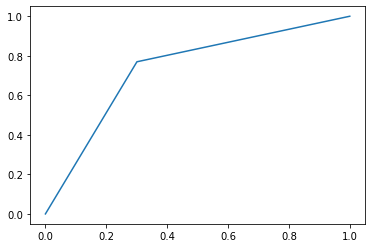

In [112]:
## Plot ROC
roc = roc_curve(pred_test_df['label_value'], pred_test_df['score'])
plt.plot(roc[0], roc[1])
plt.show()

In [113]:
#AUC - area under the ROC curve
auc = roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])
print(f'AUC: {auc}')

AUC: 0.7344960213635479



* **Precision-recall trade-off**: 

The more the model tries to eliminate false positives, (i.e. increase precision), the more the model will have to err on the side of false negatives, because it is forced to classify as "False" at the possibility that it might be False. Inevitably, this will mean that sometimes actual Positives will be classified as "False", which is the definition of False Negative. Thus, trying to minimize False Positives, increases the number of False Negatives.

The same works in the opposite direction. The more the model tries to minimize False Negatives (i.e. increase recall), the more it is forced to classify as Positive those records that have the possibility of being Positive, even though they in fact are Negative. Thus, false positive rate increases as we try to minimize false negatives.

In our case we have (weighted average) precision and recall of 0.75 and 0.73, correspondingly. They are both higher noticeably higher than 0.5, and there is no significant difference between them, which shows good trade-off balance. Although, of course, values are not too close to 1.0, which shows there's room for improvement.

* **F1-Score**

F1-score is the harmonic mean of precision and recall, thus capturing both precision and recall in a single value. It is better than using a simple average, because if one of two is small and the other large, F1-score will reflect it better than an average, which might still be pretty high. In our case the weighted F1-score average is 0.73  

* **ROC (Receiver Operating Characteristic) Curve and AUC**

A good model (something that has actually learned something from the data), would make it possible to find internal parameters/threshold where False Positive rate can be minimized while keeping False Negative rate comparatively low. This will manifest itself in the ROC-curve shape, and, particularly the more it is different from y = x shape. This difference can be measured with AUC (Area Under the Curve), which in our case is 0.73. This number is not very close to 1.0, but still, it is observably larger than 0.5, so our model definitely learned something from the data.

Refs: [F1-score](https://en.wikipedia.org/wiki/F1_score), [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

* **Potential Improvements**:
  * Explore more learning rates (we can see that validation loss somewhat bounces back and forth after 10 Epochs)
  * Try other optimizers like Adam
  * Use binary output in the network and optimize directly for AUC

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [114]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [5196]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [115]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

From the visualizations below we can deduce thus; the model shows no noticeable bias in gender (between male and female groups), and almost no bias in race, EXCEPT for PPR (Positive Predictive Rate).

PPR looks very much higher for Caucasian group (much higher precision), which also means much lower portion of False Positives among positive predictions. This, in turn, means that among the patients selected by our model for this drug program, the selected Caucasian people have a much higher chance of being actually fit (the right choice) for the program as compared to other groups, especially Asians, which will have a higher probability of NOT being a good fit for the program. This can be a useful piece of info to know in advance when working with this model.

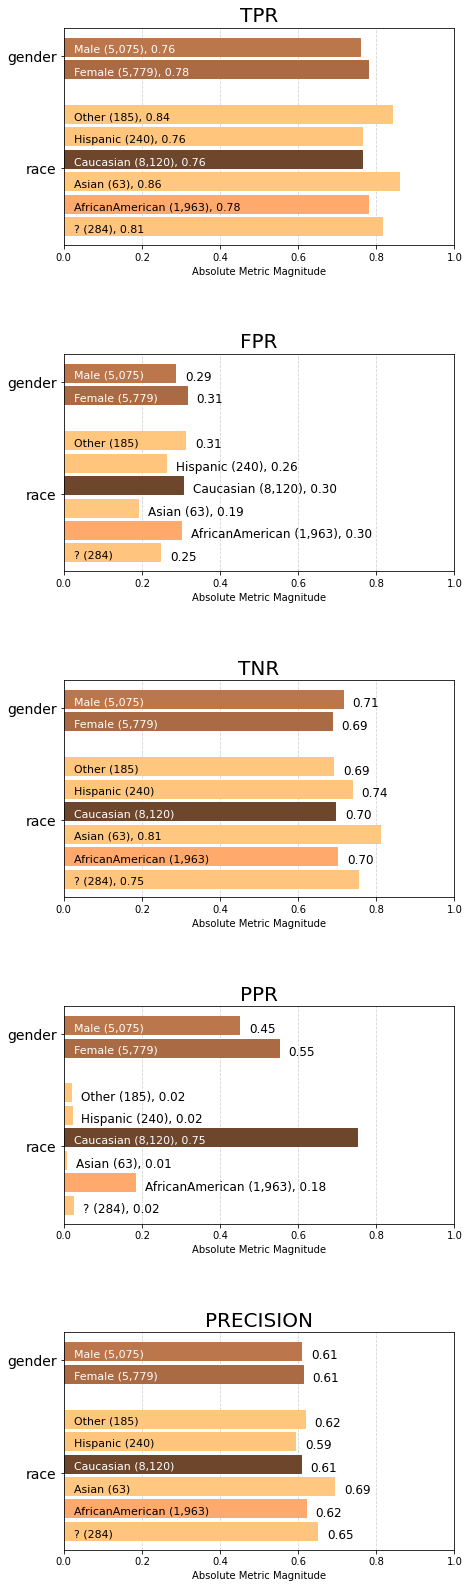

In [116]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
f, axes = plt.subplots(5, figsize=(7, 28),gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.002, ax=axes[0])
fpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.002, ax=axes[1])
tnr = aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.002, ax=axes[2])
ppr = aqp.plot_group_metric(clean_xtab, 'ppr', min_group_size=0.002, ax=axes[3])
precision = aqp.plot_group_metric(clean_xtab, 'precision', min_group_size=0.002, ax=axes[4])

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

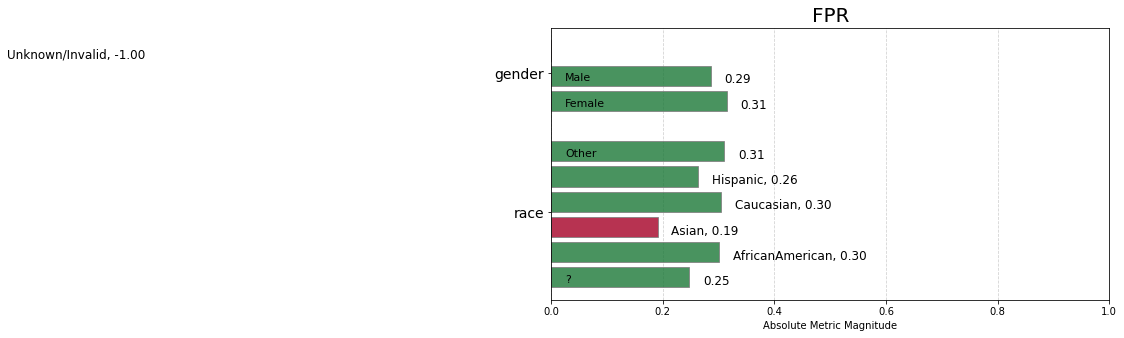

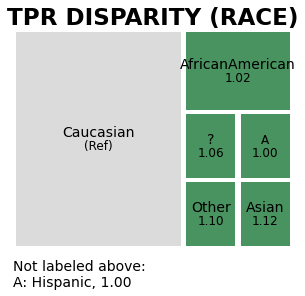

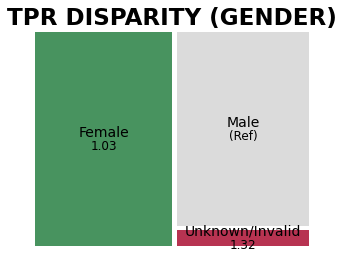

In [117]:
# Reference group fairness plot
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='race')
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='gender')

In terms of False Positive Rate, we can see that Asians do not fit for the program and have somewhat smaller probability of being selected for it, as compared to the rest. 

It has to be mentioned though, apart from Caucasians, there is no extreme TPR disparity for the other races and also no Gender disparity.